In [1]:
import numpy as np
import pandas as pd

In [2]:
import pickle

with open('./networks/HRP_network_1.pkl', 'rb') as handle:
    network = pickle.load(handle)
network['ScenarioProbabilities'] = np.array(network['ScenarioProbabilities'])

In [3]:
from src.optimization_models import tep

full_model = tep.two_stage(**network, name="TEP_HRP")
full_model, _ = tep.solve_model(full_model, verbose=True)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Aiusha\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-23
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter NodeMethod to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 40 physical cores, 80 logical processors, using up to 32 threads
Optimize a model with 3749427 rows, 2374064 columns and 9557411 nonzeros
Model fingerprint: 0x47f98ce3
Variable types: 2374012 continuous, 52 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [7e-03,

   20063 DPushes remaining with DInf 0.0000000e+00               375s
   19773 DPushes remaining with DInf 0.0000000e+00               382s
   19503 DPushes remaining with DInf 0.0000000e+00               389s
   19212 DPushes remaining with DInf 0.0000000e+00               397s
   18962 DPushes remaining with DInf 0.0000000e+00               404s
   18702 DPushes remaining with DInf 0.0000000e+00               412s
   18452 DPushes remaining with DInf 0.0000000e+00               419s
   18201 DPushes remaining with DInf 0.0000000e+00               426s
   17687 DPushes remaining with DInf 0.0000000e+00               434s
   17424 DPushes remaining with DInf 0.0000000e+00               441s
   17152 DPushes remaining with DInf 0.0000000e+00               448s
   16872 DPushes remaining with DInf 0.0000000e+00               456s
   16662 DPushes remaining with DInf 0.0000000e+00               464s
   16442 DPushes remaining with DInf 0.0000000e+00               472s
   16232 DPushes rem

In [4]:
true_x, true_fmax, true_cost = tep.get_from_model(full_model, len(network['Lines']), network['ExistingLinesNum'])

In [5]:
true_cost

8617718.01778856

In [6]:
x_range = len(true_x)
fmax_range = len(true_x) + len(true_fmax)
n_vars = fmax_range + 1

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from src.reduction.scenario_reduction import ScenarioReduction
from src.reduction.functional import reduction_analysis

n_scenarios_range = np.array([1, 5, 10, 15, 20, 25, 30, 40, 50])
models = [KMeans, AgglomerativeClustering, ScenarioReduction]
parameters_dict = {
    'KMeans' : {
        'random_state' : [42]
    },
    'AgglomerativeClustering' : {
        'linkage' : ['ward', 'average', 'single', 'complete']
    },
    'ScenarioReduction' : {
        'method' : ['Dupacova', 'Morales', 'Bruninx']
    }
}
cluster_representations = ['centroid', 'medoid']

reduction_results = reduction_analysis(
    "TEP", network, n_scenarios_range, models, parameters_dict, n_vars, None, cluster_representations, scale=True
)

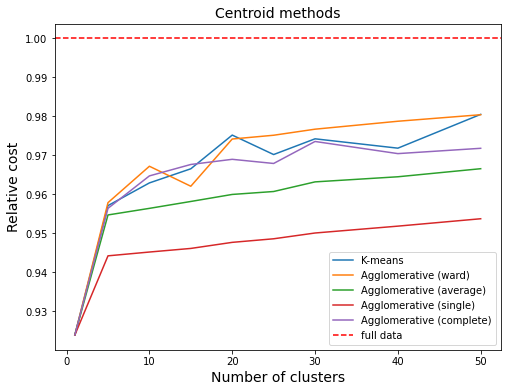

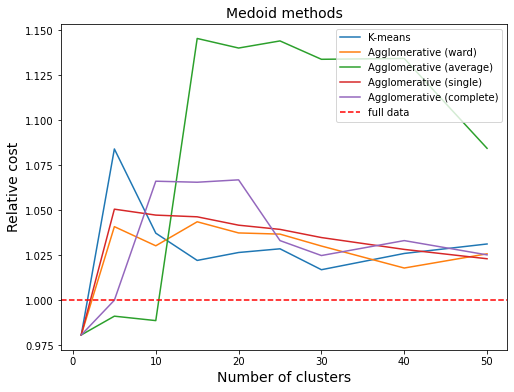

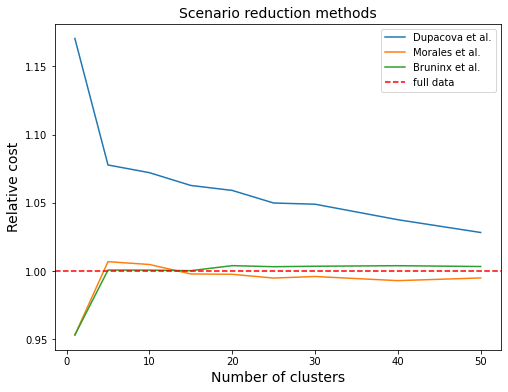

In [11]:
from src.utils.visualization import cluster_plots

centroid_methods = ['K-means', 'Agglomerative (ward)', 'Agglomerative (average)', 'Agglomerative (single)', 'Agglomerative (complete)']
cluster_plots('centroid', centroid_methods, reduction_results, true_cost, n_scenarios_range, save_name='hrp_centroid')
cluster_plots('medoid', centroid_methods, reduction_results, true_cost, n_scenarios_range, save_name='hrp_medoid')
sr_methods = ['Dupacova et al.', 'Morales et al.', 'Bruninx et al.']
cluster_plots('sr', sr_methods, reduction_results, true_cost, n_scenarios_range, save_name='hrp_sr')

In [12]:
from src.reduction.functional import run_oos_test

oos_results = run_oos_test("TEP", network, reduction_results, len(n_scenarios_range), x_range, fmax_range, name="OSS_TEP_HRP")

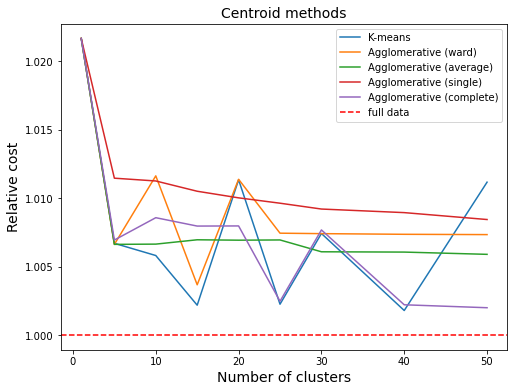

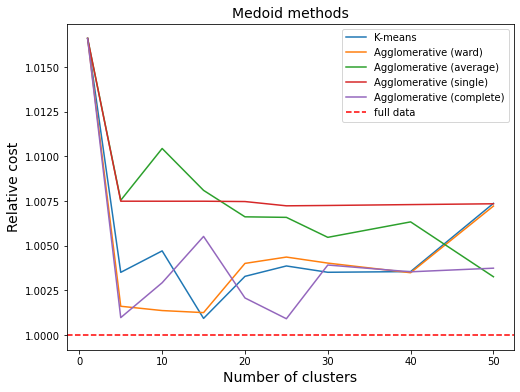

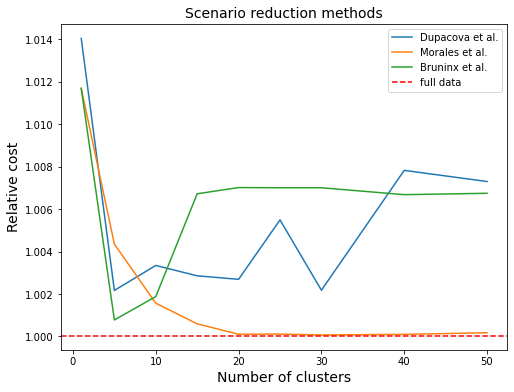

In [13]:
for method_type in ['centroid', 'medoid', 'sr']:
    oos_results[method_type] = oos_results[method_type][:, :, None]

cluster_plots('centroid', centroid_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='hrp_centroid_oos')
cluster_plots('medoid', centroid_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='hrp_medoid_oos')
cluster_plots('sr', sr_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='hrp_sr_oos')

In [22]:
centroid_idxs = (abs(reduction_results['centroid'][:, :, -1] - true_cost) / true_cost).argmin(axis=1)

In [25]:
(abs(oos_results['centroid'][np.arange(5), centroid_idxs, 0] - true_cost) / true_cost) * 100

array([1.11611514, 0.73310541, 0.58891827, 0.84323821, 0.76709703])

In [26]:
(abs(reduction_results['centroid'][np.arange(5), centroid_idxs, -1] - true_cost) / true_cost) * 100

array([1.94908022, 1.95811658, 3.34427409, 4.6291243 , 2.64499663])

In [27]:
n_scenarios_range[centroid_idxs]

array([50, 50, 50, 50, 30])

In [28]:
medoid_idxs = (abs(reduction_results['medoid'][:, :, -1] - true_cost) / true_cost).argmin(axis=1)
print((abs(oos_results['medoid'][np.arange(5), medoid_idxs, 0] - true_cost) / true_cost) * 100)
print((abs(reduction_results['medoid'][np.arange(5), medoid_idxs, -1] - true_cost) / true_cost) * 100)
n_scenarios_range[medoid_idxs]

[0.3510363  0.34851257 0.75412449 1.66019084 0.09714968]
[1.70758132 1.80172762 0.87370859 1.91826646 0.0134728 ]


array([30, 40,  5,  1,  5])

In [30]:
sr_idxs = (abs(reduction_results['sr'][:, :, -1] - true_cost) / true_cost).argmin(axis=1)
print((abs(oos_results['sr'][np.arange(3), sr_idxs, 0] - true_cost) / true_cost) * 100)
print((abs(reduction_results['sr'][np.arange(3), sr_idxs, -1] - true_cost) / true_cost) * 100)
n_scenarios_range[sr_idxs]

[0.73001196 0.05951188 0.6722978 ]
[2.82751447 0.20775069 0.03092501]


array([50, 15, 15])